In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
from tenpy.models.xxz_chain import XXZChain
from tenpy.algorithms import my_tebd as tebd
logger = logging.getLogger('/Users/alanduriez/Desktop/Python/tenpy/tenpy/algorithms/my_tebd.py')
import numpy as np
from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel,CouplingMPOModel
from tenpy.networks.site import SpinSite
from tenpy.networks.site import SpinHalfSite
from tenpy.models.lattice import Chain
from qiskit.quantum_info import Statevector,Operator
from src.utils import get_line_graph,get_heisenberg_hamiltonian,get_eigen_decomposition,get_mag_x_op,get_mag_y_op,get_mag_z_op
# logger = logging.getLogger(__name__)
import matplotlib.pyplot as plt

In [6]:
np.exp(np.pi*1.j)

np.complex128(-1+1.2246467991473532e-16j)

In [2]:
class XXZChain(CouplingModel,MPOModel):
    def __init__(self, model_params):

        L = model_params['L']
        hz = model_params['hz']
        conserve = model_params['conserve']
        Jxy = model_params['Jxy']
        Jz = model_params['Jz']
        bc = model_params['bc']
        bc_MPS = model_params['bc_MPS']
        spin = SpinHalfSite(conserve=conserve)
        # the lattice defines the geometry
        lattice = Chain(L, 
                        spin, 
                        bc=bc, 
                        bc_MPS=bc_MPS)
        CouplingModel.__init__(self, lattice)
        # add terms of the Hamiltonian
        self.add_coupling(Jxy, 0, "Sigmax", 0, "Sigmax", 1)
        self.add_coupling(Jxy, 0, "Sigmay", 0, "Sigmay", 1)
        self.add_coupling(Jz, 0, "Sigmaz", 0, "Sigmaz", 1) # interaction
        
        self.add_onsite(hz, 0, "Sigmaz") # transverse field

        # generate H_bond for TEBD
        NearestNeighborModel.__init__(self, lattice, self.calc_H_bond())
        # finish initialization
        # generate MPO for DMRG
        MPOModel.__init__(self, lattice, self.calc_H_MPO())

In [3]:
max_workers = 1
L = 8; Jxy = -0.1; Jz = -0.5; hz = 0.7
bc = 'open'
bc_MPS = 'finite'

model_params = dict(bc=bc,
                    bc_MPS =bc_MPS,
                    conserve='None',
                    L=L,
                    hz=hz,
                    Jxy=Jxy,
                    Jz=Jz)

model = XXZChain(model_params)
sites = model.lat.mps_sites()
theta, phi = np.pi/2, np.pi/2
bloch_sphere_state = np.array([np.cos(theta/2),np.sin(theta/2)])
psi = MPS.from_product_state(sites, [bloch_sphere_state] * L, bc_MPS) 

tebd_params = {
    'N_steps': 1,
    'dt': 0.1,
    'order': 4,
    'trunc_params': {'chi_max': 100, 'svd_min': 1.e-12}
}
eng = tebd.TEBDEngine(psi, model, tebd_params)
# dmrg_params = {"trunc_params": {"chi_max": 100, "svd_min": 1.e-10}, "mixer": True}
# info = dmrg.run(psi, model, dmrg_params)
# print("E =", info['E'])
# print("max. bond dimension =", max(psi.chi))

2024-08-02 14:11:34,224 - tenpy.tools.params - INFO - TEBDEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')


In [4]:
logger = logging.getLogger(__name__)

In [5]:
def measurement(eng, data):
    keys = ['t', 'Sx', 'Sy', 'Sz', 'trunc_err','entropy']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['Sx'].append(eng.psi.expectation_value('Sigmax'))
    data['Sy'].append(eng.psi.expectation_value('Sigmay'))
    data['Sz'].append(eng.psi.expectation_value('Sigmaz'))
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

data = measurement(eng, None)
while eng.evolved_time < 20.:
    eng.run()
    measurement(eng, data)

2024-08-02 14:11:34,238 - tenpy.tools.params - INFO - TEBDEngine: reading 'dt'=0.1
2024-08-02 14:11:34,238 - tenpy.tools.params - INFO - TEBDEngine: reading 'N_steps'=1
2024-08-02 14:11:34,239 - tenpy.tools.params - INFO - TEBDEngine: reading 'order'=4
2024-08-02 14:11:34,239 - tenpy.algorithms.my_tebd - INFO - Calculate U for {'order': 4, 'delta_t': 0.1, 'type_evo': 'real', 'E_offset': None, 'tau': 0.1}
2024-08-02 14:11:34,257 - tenpy.tools.params - INFO - trunc_params: reading 'chi_max'=100
2024-08-02 14:11:34,258 - tenpy.tools.params - INFO - trunc_params: reading 'svd_min'=1e-12
2024-08-02 14:11:34,289 - tenpy.algorithms.algorithm - INFO - --> time=0.100, max(chi)=8, max(S)=0.01191, avg DeltaS=1.1904e-02, since last update: 0.1s
2024-08-02 14:11:34,326 - tenpy.algorithms.algorithm - INFO - --> time=0.200, max(chi)=10, max(S)=0.03879, avg DeltaS=2.6869e-02, since last update: 0.0s
2024-08-02 14:11:34,361 - tenpy.algorithms.algorithm - INFO - --> time=0.300, max(chi)=10, max(S)=0.075

In [6]:
mx = []
my = []
mz = []
for i in range(len(data['Sx'])):
    mx.append(np.sum(data['Sx'][i]))
    my.append(np.sum(data['Sy'][i]))
    mz.append(np.sum(data['Sz'][i]))

In [7]:
graph=get_line_graph(L)
heisenberg_hamiltonian = get_heisenberg_hamiltonian(graph,Jxy=Jxy,Jz=Jz,hz=hz)
eig_vals,eig_matrix = get_eigen_decomposition(heisenberg_hamiltonian.to_matrix())
initial_state = Statevector.from_label('+'* L)

mag_z = get_mag_z_op(graph)
mag_x = get_mag_x_op(graph)
mag_y = get_mag_y_op(graph)

mags_z = []
mags_x = []
mags_y = []
times = np.linspace(0,20,100)
for t in times:
    # U = Operator(expm(-1.j*t*heisenberg_hamiltonian.to_matrix()))
    U = Operator(eig_matrix @ np.diag(np.exp(-1.j*t*eig_vals)) @ eig_matrix.T)
    evolved_state = initial_state.evolve(U)
    
    mags_x.append(evolved_state.expectation_value(mag_x))
    mags_y.append(evolved_state.expectation_value(mag_y))
    mags_z.append(evolved_state.expectation_value(mag_z))

In [8]:
def get_exact_mags(L = 8, Jxy = -0.1,Jz = -0.5,hz = 0.7):
    graph=get_line_graph(L)
    heisenberg_hamiltonian = get_heisenberg_hamiltonian(graph,Jxy=Jxy,Jz=Jz,hz=hz)
    eig_vals,eig_matrix = get_eigen_decomposition(heisenberg_hamiltonian.to_matrix())
    initial_state = Statevector.from_label('+'* L)

    mag_z = get_mag_z_op(graph)
    mag_x = get_mag_x_op(graph)
    mag_y = get_mag_y_op(graph)

    mags_z = []
    mags_x = []
    mags_y = []
    times = np.linspace(0,20,100)
    for t in times:
        # U = Operator(expm(-1.j*t*heisenberg_hamiltonian.to_matrix()))
        U = Operator(eig_matrix @ np.diag(np.exp(-1.j*t*eig_vals)) @ eig_matrix.T)
        evolved_state = initial_state.evolve(U)
        
        mags_x.append(evolved_state.expectation_value(mag_x))
        mags_y.append(evolved_state.expectation_value(mag_y))
        mags_z.append(evolved_state.expectation_value(mag_z))
    return mags_x,mags_y,mags_z

mags_x,mags_y,mags_z = get_exact_mags()

In [101]:
h = model.H_bond[1]
print(h)
h.to_ndarray()

<npc.Array shape=(2, 2, 2, 2) labels=['p0', 'p0*', 'p1', 'p1*']
charge=ChargeInfo([], [])
 +1 | -1 | +1 | -1 
0 []|0 []|0 []|0 []
2   |2   |2   |2   
[[[[ 0.55+0.j  0.  +0.j]
   [ 0.  +0.j  0.85+0.j]]

  [[ 0.  +0.j  0.  +0.j]
   [-0.2 +0.j  0.  +0.j]]]


 [[[ 0.  +0.j -0.2 +0.j]
   [ 0.  +0.j  0.  +0.j]]

  [[ 0.15+0.j  0.  +0.j]
   [ 0.  +0.j -1.55+0.j]]]]
>


array([[[[ 0.55+0.j,  0.  +0.j],
         [ 0.  +0.j,  0.85+0.j]],

        [[ 0.  +0.j,  0.  +0.j],
         [-0.2 +0.j,  0.  +0.j]]],


       [[[ 0.  +0.j, -0.2 +0.j],
         [ 0.  +0.j,  0.  +0.j]],

        [[ 0.15+0.j,  0.  +0.j],
         [ 0.  +0.j, -1.55+0.j]]]])

In [102]:
H2 = h.combine_legs([('p0', 'p1'), ('p0*', 'p1*')], qconj=[+1, -1])
H2

<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']>

In [104]:
from tenpy.linalg import np_conserved as npc

print(npc.tensordot(H2,H2,axes=(1,0)))

<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']
charge=ChargeInfo([], [])
LegPipe(shape (2, 2)->4,    |LegPipe(shape (2, 2)->4,    
    qconj (+1, +1)->+1;     |    qconj (-1, -1)->-1;     
    block numbers (1, 1)->1)|    block numbers (1, 1)->1)
 +1  |  +1                  | -1  |  -1                  
0 [] | 0 []                 |0 [] | 0 []                 
2    | 2                    |2    | 2                    
)                           |)                           
[[ 0.3025+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7625+0.j -0.2   +0.j  0.    +0.j]
 [ 0.    +0.j -0.2   +0.j  0.0625+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  2.4025+0.j]]
>


In [88]:
print(H2)

<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']
charge=ChargeInfo([], [])
LegPipe(shape (2, 2)->4,    |LegPipe(shape (2, 2)->4,    
    qconj (+1, +1)->+1;     |    qconj (-1, -1)->-1;     
    block numbers (1, 1)->1)|    block numbers (1, 1)->1)
 +1  |  +1                  | -1  |  -1                  
0 [] | 0 []                 |0 [] | 0 []                 
2    | 2                    |2    | 2                    
)                           |)                           
[[ 0.55+0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.85+0.j -0.2 +0.j  0.  +0.j]
 [ 0.  +0.j -0.2 +0.j  0.15+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -1.55+0.j]]
>


In [105]:
truth = npc.expm(H2)
print(truth)
truth

<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']
charge=ChargeInfo([], [])
LegPipe(shape (2, 2)->4,    |LegPipe(shape (2, 2)->4,    
    qconj (+1, +1)->+1;     |    qconj (-1, -1)->-1;     
    block numbers (1, 1)->1)|    block numbers (1, 1)->1)
 +1  |  +1                  | -1  |  -1                  
0 [] | 0 []                 |0 [] | 0 []                 
2    | 2                    |2    | 2                    
)                           |)                           
[[ 1.73325302+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  2.37731217+0.j -0.33874767+0.j  0.        +0.j]
 [ 0.        +0.j -0.33874767+0.j  1.19169533+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.21224797+0.j]]
>


<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']>

In [121]:
cnot_gate = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
c = truth.copy(deep=True)
print(c)
c._data = [cnot_gate]
print(c)


<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']
charge=ChargeInfo([], [])
LegPipe(shape (2, 2)->4,    |LegPipe(shape (2, 2)->4,    
    qconj (+1, +1)->+1;     |    qconj (-1, -1)->-1;     
    block numbers (1, 1)->1)|    block numbers (1, 1)->1)
 +1  |  +1                  | -1  |  -1                  
0 [] | 0 []                 |0 [] | 0 []                 
2    | 2                    |2    | 2                    
)                           |)                           
[[ 1.73325302+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  2.37731217+0.j -0.33874767+0.j  0.        +0.j]
 [ 0.        +0.j -0.33874767+0.j  1.19169533+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.21224797+0.j]]
>
<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']
charge=ChargeInfo([], [])
LegPipe(shape (2, 2)->4,    |LegPipe(shape (2, 2)->4,    
    qconj (+1, +1)->+1;     |    qconj (-1, -1)->-1;     
    block numbers (1, 1)->1)|    block numb

In [117]:
a  = np.array([[ 1.73325302+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  2.37731217+0.j, -0.33874767+0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.33874767+0.j,  1.19169533+0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.21224797+0.j]])

In [115]:
c._data

[array([[ 1.73325302+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  2.37731217+0.j, -0.33874767+0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.33874767+0.j,  1.19169533+0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.21224797+0.j]])]

In [92]:
cnot_gate = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

# cnot_gate = npc.Array.from_ndarray(cnot_gate,labels=['(p0.p1)', '(p0*.p1*)'],legcharges=[truth.get_leg(0).to_LegCharge(),truth.get_leg(1).to_LegCharge()])
print(cnot_gate)

<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']
charge=ChargeInfo([], [])
 +1 | -1 
0 []|0 []
4   |4   
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
>


In [76]:
tensor = npc.tensordot(truth,cnot_gate,axes=['(p0.p1)', '(p0*.p1*)'])
tensor.to_ndarray()

array([[ 1.73325302+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j,  2.37731217+0.j, -0.33874767+0.j,
         0.        +0.j],
       [ 0.        +0.j, -0.33874767+0.j,  1.19169533+0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.21224797+0.j]])

In [35]:
tensor.

<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']>

In [34]:
print(model.H_bond[1].combine_legs([('p0', 'p1'), ('p0*', 'p1*')], qconj=[+1, -1]))

<npc.Array shape=(4, 4) labels=['(p0.p1)', '(p0*.p1*)']
charge=ChargeInfo([], [])
LegPipe(shape (2, 2)->4,    |LegPipe(shape (2, 2)->4,    
    qconj (+1, +1)->+1;     |    qconj (-1, -1)->-1;     
    block numbers (1, 1)->1)|    block numbers (1, 1)->1)
 +1  |  +1                  | -1  |  -1                  
0 [] | 0 []                 |0 [] | 0 []                 
2    | 2                    |2    | 2                    
)                           |)                           
[[ 0.55+0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.85+0.j -0.2 +0.j  0.  +0.j]
 [ 0.  +0.j -0.2 +0.j  0.15+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -1.55+0.j]]
>


In [125]:
a = 2
if a == 2 or 3:
    print()

3


In [122]:
a = {}
if a:
    print(2)

/Users/alanduriez/miniconda3/envs/tenpy_dev/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/alanduriez/miniconda3/envs/tenpy_dev/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'time $t$')

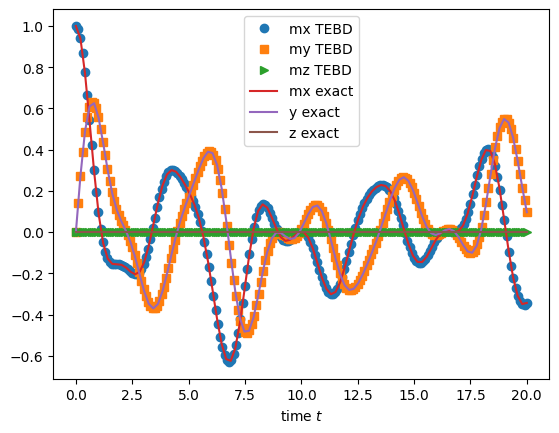

In [20]:
plt.plot(data['t'], mx/np.array(L),'o',label='mx TEBD')
plt.plot(data['t'], my/np.array(L),'s',label='my TEBD')
plt.plot(data['t'], mz/np.array(L),'>',label='mz TEBD')
plt.plot(times,mags_x,label='mx exact')
plt.plot(times,mags_y,label='y exact')
plt.plot(times,mags_z,label='z exact')
plt.legend()
plt.xlabel('time $t$')

Text(0, 0.5, 'entropy $S$')

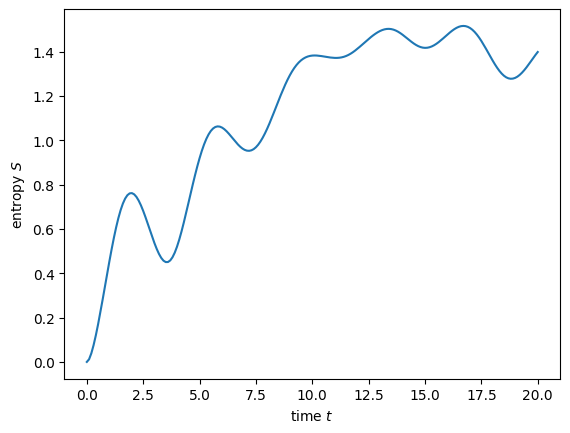

In [21]:
plt.plot(data['t'], np.array(data['entropy'])[:, L//2])
plt.xlabel('time $t$')
plt.ylabel('entropy $S$')